# ViT

Practice of code in this article

Brian Pulfer. 2022. [Vision Transformers from Scratch (PyTorch): A step-by-step guide](https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c). MLearning.ai.

Code link: https://github.com/BrianPulfer/PapersReimplementations/blob/main/vit/vit_torch.py

Implementation is basically the same. Added some comments and notes.

In [2]:
import numpy as np
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

- Patchify
  - The resulting number of patches $N=HW/P^2$
- Classification Token
- Positional Encoding
- Encoder Block
- MLP

```
class ViTModel(nn.Module):
  def __init__(self):
    super(ViTModel, self).__init__()

  def forward(self, images):
    pass
```

## Patchify

In [3]:
def patchify(images, n_patches):
  n, c, h, w = images.shape # num, channel, height, width

  assert h == w, "Patchify method is implemented for square images only"

  patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2) # patched shape
  patch_size = h // n_patches # size of each patch

  for idx, image in enumerate(images):
    for i in range(n_patches):
      for j in range(n_patches):
        patch = image[:, i*patch_size : (i+1)*patch_size, j*patch_size : (j+1)*patch_size]
        patches[idx, i * n_patches + j] = patch.flatten()
  return patches

In [4]:
def get_positional_embeddings(seq_len, d):
  result = torch.ones(seq_len, d)
  for i in range(seq_len):
    for j in range(d):
      result[i][j] = np.sin(i / (1000 ** (j/d))) if j % 2 == 0 else np.cos(i / (1000 ** ((j-1) / d)))
  return result

## MultiHeadAttention

In [5]:
class MultiHeadAttention(nn.Module):
  def __init__(self,
               embedding_dim,
               num_heads = 2,
               dropout = 0):
    super().__init__()
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads

    assert embedding_dim % num_heads == 0, f"Can't divide dimension {embedding_dim} into {num_heads} heads"

    head_dim = int(embedding_dim / num_heads)
    self.head_dim = head_dim
    self.query_mapping = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(self.num_heads)])
    self.key_mapping = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(self.num_heads)])
    self.value_mapping = nn.ModuleList([nn.Linear(head_dim, head_dim) for _ in range(self.num_heads)])
    self.softmax = nn.Softmax(dim = -1)

  def forward(self, sequences):
    result = []
    for sequence in sequences:
      seq_result = []
      for head in range(self.num_heads):
        query_mapping = self.query_mapping[head]
        key_mapping = self.key_mapping[head]
        value_mapping = self.value_mapping[head]

        seq = sequence[:, head * self.head_dim : (head+1) * self.head_dim]
        q, k, v = query_mapping(seq), key_mapping(seq), value_mapping(seq)

        attention = self.softmax(q @ k.T / self.head_dim ** 0.5)
        seq_result.append(attention @ v)
      result.append(torch.hstack(seq_result))
    return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


## ViT Block

In [6]:
class ViTBlock(nn.Module):
  def __init__(self,
               hidden_d,
               n_heads,
               mlp_ratio=4):
    super(ViTBlock, self).__init__()
    self.hidden_d = hidden_d
    self.n_heads = n_heads

    self.layernorm1 = nn.LayerNorm(hidden_d)
    self.layernorm1 = nn.LayerNorm(hidden_d)
    self.mhattn = MultiHeadAttention(hidden_d, n_heads)
    self.mlp = nn.Sequential(nn.Linear(hidden_d, mlp_ratio * hidden_d),
                             nn.GELU(),
                             nn.Linear(mlp_ratio * hidden_d, hidden_d)
                             )

  def forward(self, x):
    out = x + self.mhattn(self.layernorm1(x))
    return out

In [7]:
# Test ViTBlock
model = ViTBlock(hidden_d=8, n_heads=2)
x = torch.randn(7, 50, 8)  # Dummy sequences
print(model(x).shape)

torch.Size([7, 50, 8])


## ViT Model

In [13]:
class ViTModel(nn.Module):
  def __init__(self,
               chw=(1, 28, 28),
               n_patches = 7,
               n_blocks = 2,
               hidden_d = 8,
               n_heads = 2,
               out_d = 10,
               ):
    super(ViTModel, self).__init__()

    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.n_blocks = n_blocks
    self.n_heads = n_heads
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # Linear mapper
    self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # Learnable classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    # Positional embedding
    self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
    # self.pos_embed = nn.Parameter(torch.tensor(get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden_d)))
    # self.pos_embed.requires_grad = False

    # encoder blocks
    self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

    # MLP
    self.mlp = nn.Sequential(
        nn.Linear(self.hidden_d, out_d),
        nn.Softmax(dim=-1)
        )

  def forward(self, images):
    n, c, h, w = images.shape
    patches = patchify(images, self.n_patches)
    patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
    tokens = self.linear_mapper(patches)
    # Add classification token ahead of each patch
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Add positional embeddings
    out = tokens + self.positional_embeddings.repeat(n, 1, 1)

    for block in self.blocks:
      out = block(out)

    out = out[:, 0]

    return self.mlp(out)

In [9]:
# model = ViTModel(
#     chw=(1, 28, 28),
#     n_patches = 7
# )
# x = torch.randn(7, 1, 28, 28)
# print(model(x).shape)

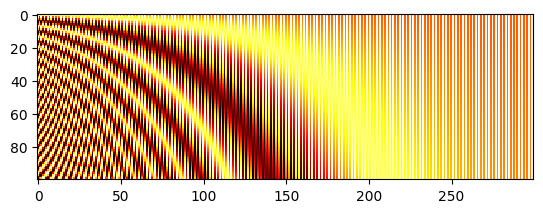

In [10]:
# Test positional encoding
import matplotlib.pyplot as plt
plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
plt.show()

## Train + Test

In [14]:
transform = ToTensor()
train_set = MNIST(root="./../datasets", train=True, download=True, transform=transform)
test_set = MNIST(root="./../datasets", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model = ViTModel(chw=(1, 28, 28),
                 n_patches = 7,
                 n_blocks = 2,
                 hidden_d = 8,
                 n_heads = 2,
                 out_d=10).to(device)

Device: cuda


In [15]:
N_EPOCHS = 5
LR = 0.005

optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# Training
for epoch in trange(N_EPOCHS):
  train_loss = 0.0
  train_acc = 0.0
  for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
    inputs, labels = data
    inputs = inputs.to(device) # move data to gpu
    labels = labels.to(device)
    outputs = model(inputs) # get model outputs
    loss = criterion(outputs, labels)
    optimizer.zero_grad() # clean gradient
    loss.backward()
    optimizer.step()
    train_loss += loss.detach().cpu().item() / len(train_loader)
    _, predicted = torch.max(outputs.data, dim=1)
    train_acc += (predicted == labels).sum().item() / len(train_loader)
  print(f"Epoch {epoch+1}/{N_EPOCHS}, train loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")

 20%|██        | 1/5 [07:45<31:00, 465.17s/it]

Epoch 1/5, train loss: 2.080, train_acc: 48.414



 40%|████      | 2/5 [15:14<22:47, 455.76s/it]

Epoch 2/5, train loss: 1.919, train_acc: 69.755



 60%|██████    | 3/5 [22:42<15:04, 452.18s/it]

Epoch 3/5, train loss: 1.865, train_acc: 76.375



 80%|████████  | 4/5 [30:12<07:31, 451.53s/it]

Epoch 4/5, train loss: 1.843, train_acc: 79.126



100%|██████████| 5/5 [37:43<00:00, 452.66s/it]

Epoch 5/5, train loss: 1.828, train_acc: 81.275


In [17]:
# Test
with torch.no_grad():
  correct, totoal = 0, 0
  test_loss = 0.0
  test_acc = 0.0
  for data in tqdm(test_loader, desc=f"Testing"):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.detach().cpu().item() / len(test_loader)
    _, predicted = torch.max(outputs.data, dim=1)
    test_acc += (predicted == labels).sum().item() / len(test_loader)
  print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

Testing: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]

test_loss: 1.822, test_acc: 80.949
